# Laboratorio 06 - Análisis de redes sociales

### Problema 01: @TráficoGT

In [178]:
import pandas as pd
import unicodedata
import string
import nltk
import re
from nltk.corpus import stopwords
from collections import Counter

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import networkx as nx

import community as community_louvain 
import collections

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import json
from datetime import datetime
import seaborn as sns

### Carga de datos

In [179]:
def load_twitter_data(file_path):
    """
    Carga datos de Twitter removiendo BOM y caracteres problemáticos
    """
    tweets = []
    
    with open(file_path, 'r', encoding='utf-16') as file:  # Cambio a utf-16 por el BOM
        for line_num, line in enumerate(file, 1):
            line = line.strip()
            
            # Saltar líneas vacías
            if not line:
                continue
                
            # Remover BOM si existe al inicio de la línea
            if line.startswith('\ufeff'):
                line = line[1:]
            
            try:
                tweet = json.loads(line)
                tweets.append(tweet)
            except json.JSONDecodeError as e:
                if line_num <= 5:  
                    print(f"Error en línea {line_num}: {str(e)[:50]}...")
                continue
    
    return tweets

In [180]:
def create_dataframe(tweets):
    """
    Convierte los tweets a DataFrame
    """
    data = []
    
    for tweet in tweets:
        data.append({
            'id': tweet.get('id_str'),
            'fecha': tweet.get('date'),
            'usuario': tweet.get('user', {}).get('username'),
            'nombre_completo': tweet.get('user', {}).get('displayname'),
            'contenido': tweet.get('rawContent'),
            'retweets': tweet.get('retweetCount', 0),
            'likes': tweet.get('likeCount', 0),
            'respuestas': tweet.get('replyCount', 0),
            'citas': tweet.get('quoteCount', 0),
            'vistas': tweet.get('viewCount', 0),
            'idioma': tweet.get('lang')
        })
    
    return pd.DataFrame(data)

In [181]:
file_path = 'traficogt.txt'
tweets_data = load_twitter_data(file_path)
df = create_dataframe(tweets_data)

print(f"Datos cargados: {len(df)} tweets")

Datos cargados: 5604 tweets


### Inspección Inicial

In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5604 entries, 0 to 5603
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               5604 non-null   object 
 1   fecha            5604 non-null   object 
 2   usuario          5604 non-null   object 
 3   nombre_completo  5604 non-null   object 
 4   contenido        5604 non-null   object 
 5   retweets         5604 non-null   int64  
 6   likes            5604 non-null   int64  
 7   respuestas       5604 non-null   int64  
 8   citas            5604 non-null   int64  
 9   vistas           5600 non-null   float64
 10  idioma           5604 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 481.7+ KB


In [183]:
display(df.head())

,id,fecha,usuario,nombre_completo,contenido,retweets,likes,respuestas,citas,vistas,idioma
0,1834236045598056867,2024-09-12 14:22:06+00:00,traficogt,traficoGT,Es comprensible la resolución... El ruso sabe de engrasar maquinaria.,0,1,0,0,393.0,es
1,1834029142565658846,2024-09-12 00:39:56+00:00,monymmorales,Mony,"La corrupción de la @CC_Guatemala\nes descarada, falsificación de documentos y obligaron a extenderles DPI.\nhttps://t.co/0J24ZCXJ2c",56,84,0,4,1587.0,es
2,1834039491826180424,2024-09-12 01:21:04+00:00,animaldgalaccia,Jairo De La Nada,@PNCdeGuatemala @mingobguate @FJimenezmingob @diegoedeleon @amilcarmontejo @traficogt \n\n🚨🚨🚨🚨🚨,0,1,0,0,91.0,qme
3,1833963729136091179,2024-09-11 20:20:01+00:00,EstacionDobleA,Estación Doble A,@amilcarmontejo @AztecaNoticiaGT @BancadaSemilla @BArevalodeLeon @diputadojp @EmisorasUnidas @eP_investiga @ImpactoNoticiGT @lahoragt @mingobguate @PrensaComunitar @Transito_mixco @DGTguate @PMT_VILLANUEVA @InfoTransitoGt @traficogt @PMT_SanJuanSac @PMTSanLucasSac @YenerPlaza,0,0,0,0,46.0,qam
4,1833665391698092330,2024-09-11 00:34:31+00:00,CubReserva,CUB Reserva Kanajuyu Z 16,"@soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEMPAGUA @muniguate @GuatemalaGob @Guatevision_tv @pattyo502 @karinapazGt @Josechic86 @vecinosz16 URGENTE zona 16 en deterioro por tala inmoderada, el tráfico es desesperante @traficogt @EmisorasUnidas @eP_investiga @IsaPaiz_",0,1,0,0,171.0,es


In [184]:
display(df.tail())

,id,fecha,usuario,nombre_completo,contenido,retweets,likes,respuestas,citas,vistas,idioma
5599,1711138940990722120,2023-10-08 21:58:09+00:00,guiselabarrios,Guisela Barrios,"@traficogt Y no que presentando 5 mil firmas ante el Congrueso de ratas, si procedería la destitución de la “comosiama”.",0,0,0,0,8.0,es
5600,1711133805182869820,2023-10-08 21:37:45+00:00,mvtrooper,Eduardo Marroquín,@hshetemul @traficogt Y de igual Manera quitan el derecho de repuesta al pueblo en sus publicaciones al Estilo del corrupto @MPguatemala!\n\nSin ninguna duda son parte de este sistema podrido @CangGuatemala,0,0,0,0,3.0,es
5601,1711133697552810362,2023-10-08 21:37:19+00:00,elmeronene1,elmeronene,@traficogt Es algo más fuerte que ellos no quieren que se sepa por eso es que no renuncian,0,0,0,0,21.0,es
5602,1711132207631212797,2023-10-08 21:31:24+00:00,mvtrooper,Eduardo Marroquín,@Factor4_GT @traficogt @CC_Guatemala @MPguatemala https://t.co/o2bCGkJiEU,0,0,0,0,4.0,qme
5603,1711127715741417476,2023-10-08 21:13:33+00:00,91072dff5a5a4f1,Helmuttt,@AgenciaOcote @traficogt Vieja ignorante,0,0,0,0,17.0,es


### Limpieza y Preprocesamiento de datos

In [185]:
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

SPANISH_STOPWORDS = set(stopwords.words('spanish'))

In [186]:
CUSTOM_STOPWORDS = {'q', 'asi', 'mas', 'jajaja', 'va', 'ahora', 'da', 'pasa', 'sera', 'siempre', 'ano', 'pue', 'bien', 'debe', 'nadie', 'hace', 'dice', 'vos', 'ir', 'cosa', 'paso', 'tan', 'pasa', 'sera', 'ver', 'hshetmul' }  
STOPWORDS = SPANISH_STOPWORDS.union(CUSTOM_STOPWORDS)

URL_RE = re.compile(r'https?://\S+|www\.\S+', re.IGNORECASE)
MENTION_RE = re.compile(r'@\w+')
HASHTAG_RE = re.compile(r'#\w+')
EMOJI_RE = re.compile(r'[\U00010000-\U0010ffff]', flags=re.UNICODE)

In [187]:
def normalize_username(u):
    """Normaliza nombres de usuario (minúsculas, sin espacios)."""
    if pd.isna(u):
        return u
    return str(u).strip().lower()

def clean_text(text: str):
    """Limpieza avanzada del texto del tweet."""
    if pd.isna(text):
        return ''
    t = text
    t = URL_RE.sub(' ', t)                          # Eliminar URLs
    t = EMOJI_RE.sub(' ', t)                        # Eliminar emojis
    t = t.lower()                                   # A minúsculas
    t = unicodedata.normalize('NFKD', t)            # Normalizar acentos
    t = ''.join(ch for ch in t if not unicodedata.combining(ch))
    t = t.translate(str.maketrans('', '', string.punctuation))  # Eliminar puntuación
    t = re.sub(r'\d+', ' ', t)                      # Eliminar números
    tokens = [w for w in re.findall(r'\b\w+\b', t) if w not in STOPWORDS]
    return ' '.join(tokens)

def extract_mentions(text: str):
    """Extrae menciones (@usuario)."""
    return [m.lower() for m in MENTION_RE.findall(text or '')]

def extract_hashtags(text: str):
    """Extrae hashtags (#tema)."""
    return [h.lower() for h in HASHTAG_RE.findall(text or '')]

def is_retweet(text: str):
    """Detecta si es retweet."""
    return bool(re.match(r'^\s*rt\s*@', str(text).lower()))

def is_reply(text: str):
    """Detecta si es reply (respuesta directa)."""
    return bool(re.match(r'^\s*@', str(text).lower()))


In [188]:
df['usuario'] = df['usuario'].map(normalize_username)
df['contenido_limpio'] = df['contenido'].map(clean_text)
df['menciones'] = df['contenido'].map(extract_mentions)
df['hashtags'] = df['contenido'].map(extract_hashtags)
df['is_retweet'] = df['contenido'].map(is_retweet)
df['is_reply'] = df['contenido'].map(is_reply)
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')

df = df.drop_duplicates(subset=['usuario', 'contenido', 'fecha']).reset_index(drop=True)

pd.set_option("display.max_colwidth", None)
display(df[['usuario', 'contenido', 'contenido_limpio', 'menciones', 'hashtags']].head(10))

,usuario,contenido,contenido_limpio,menciones,hashtags
0,traficogt,Es comprensible la resolución... El ruso sabe de engrasar maquinaria.,comprensible resolucion ruso sabe engrasar maquinaria,[],[]
1,monymmorales,"La corrupción de la @CC_Guatemala\nes descarada, falsificación de documentos y obligaron a extenderles DPI.\nhttps://t.co/0J24ZCXJ2c",corrupcion ccguatemala descarada falsificacion documentos obligaron extenderles dpi,[@cc_guatemala],[]
2,animaldgalaccia,@PNCdeGuatemala @mingobguate @FJimenezmingob @diegoedeleon @amilcarmontejo @traficogt \n\n🚨🚨🚨🚨🚨,pncdeguatemala mingobguate fjimenezmingob diegoedeleon amilcarmontejo traficogt,"[@pncdeguatemala, @mingobguate, @fjimenezmingob, @diegoedeleon, @amilcarmontejo, @traficogt]",[]
3,estaciondoblea,@amilcarmontejo @AztecaNoticiaGT @BancadaSemilla @BArevalodeLeon @diputadojp @EmisorasUnidas @eP_investiga @ImpactoNoticiGT @lahoragt @mingobguate @PrensaComunitar @Transito_mixco @DGTguate @PMT_VILLANUEVA @InfoTransitoGt @traficogt @PMT_SanJuanSac @PMTSanLucasSac @YenerPlaza,amilcarmontejo aztecanoticiagt bancadasemilla barevalodeleon diputadojp emisorasunidas epinvestiga impactonoticigt lahoragt mingobguate prensacomunitar transitomixco dgtguate pmtvillanueva infotransitogt traficogt pmtsanjuansac pmtsanlucassac yenerplaza,"[@amilcarmontejo, @aztecanoticiagt, @bancadasemilla, @barevalodeleon, @diputadojp, @emisorasunidas, @ep_investiga, @impactonoticigt, @lahoragt, @mingobguate, @prensacomunitar, @transito_mixco, @dgtguate, @pmt_villanueva, @infotransitogt, @traficogt, @pmt_sanjuansac, @pmtsanlucassac, @yenerplaza]",[]
4,cubreserva,"@soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEMPAGUA @muniguate @GuatemalaGob @Guatevision_tv @pattyo502 @karinapazGt @Josechic86 @vecinosz16 URGENTE zona 16 en deterioro por tala inmoderada, el tráfico es desesperante @traficogt @EmisorasUnidas @eP_investiga @IsaPaiz_",aztecanoticiagt conapgt denunciaempagua muniguate guatemalagob guatevisiontv pattyo karinapazgt josechic vecinosz urgente zona deterioro tala inmoderada trafico desesperante traficogt emisorasunidas epinvestiga isapaiz,"[@soy_502, @aztecanoticiagt, @conapgt, @denunciaempagua, @muniguate, @guatemalagob, @guatevision_tv, @pattyo502, @karinapazgt, @josechic86, @vecinosz16, @traficogt, @emisorasunidas, @ep_investiga, @isapaiz_]",[]
5,alejandro2024gt,"@amilcarmontejo @PMTMuniGuate @Noti7Guatemala @NuestroDiario @T13Noticias @AztecaGuate @traficogt hay avenidas y calles (11 avenida 8 a la 12 calle) sin luz, semáforo y sin agentes de emetra .",amilcarmontejo pmtmuniguate noti guatemala nuestrodiario t noticias aztecaguate traficogt avenidas calles avenida calle luz semaforo agentes emetra,"[@amilcarmontejo, @pmtmuniguate, @noti7guatemala, @nuestrodiario, @t13noticias, @aztecaguate, @traficogt]",[]
6,julyponce21,Favor compartir \nEl vive el zona 7 Bethania \n@traficogt @amilcarmontejo @PNCdeGuatemala #urgente #Desaparecido https://t.co/LcIJv0Ffsj,favor compartir vive zona bethania traficogt amilcarmontejo pncdeguatemala urgente desaparecido,"[@traficogt, @amilcarmontejo, @pncdeguatemala]","[#urgente, #desaparecido]"
7,cubreserva,@traficogt @_ojoconmipisto @soy_502 @AztecaNoticiaGT @AztecaNoticiaGT @muniguate @CONAPgt @DenunciaEMPAGUA @EmisorasUnidas @eP_investiga @luisvengt @samuel_pz @Josechic86 @CiudadCayala @marnguate @karinapazGt @vecinosz16 es importante ponerle atención a los vecinos de z 16 https://t.co/vRDMtvj36F,traficogt ojoconmipisto aztecanoticiagt aztecanoticiagt muniguate conapgt denunciaempagua emisorasunidas epinvestiga luisvengt samuelpz josechic ciudadcayala marnguate karinapazgt vecinosz importante ponerle atencion vecinos z,"[@traficogt, @_ojoconmipisto, @soy_502, @aztecanoticiagt, @aztecanoticiagt, @muniguate, @conapgt, @denunciaempagua, @emisorasunidas, @ep_investiga, @luisvengt, @samuel_pz, @josechic86, @ciudadcayala, @marnguate, @karinapazgt, @vecinosz16]",[]
8,alexdel92022343,@piero_coen @FJimenezmingob @traficogt @mingobguate @PNCdeGuatemala @DiariodeCA @AGN_noticias @R

### Análisis Exploratorio

In [189]:
total_tweets = len(df)
usuarios_unicos = df['usuario'].nunique()
total_menciones = df['menciones'].map(len).sum()
total_hashtags = df['hashtags'].map(len).sum()
total_retweets = df['is_retweet'].sum()
total_respuestas = df['is_reply'].sum()

print("---Métricas generales---")
print(f"- Tweets totales: {total_tweets}")
print(f"- Usuarios únicos: {usuarios_unicos}")
print(f"- Total de menciones: {total_menciones}")
print(f"- Total de hashtags: {total_hashtags}")
print(f"- Total de retweets: {total_retweets}")
print(f"- Total de respuestas: {total_respuestas}")

---Métricas generales---
- Tweets totales: 5596
- Usuarios únicos: 2071
- Total de menciones: 11009
- Total de hashtags: 592
- Total de retweets: 0
- Total de respuestas: 4158


In [190]:
top_usuarios = df['usuario'].value_counts().head(10)
print("\nUsuarios más activos:")
print(top_usuarios)


Usuarios más activos:
usuario
traficogt          781
batallonjalapa     133
mildred_gaitan     103
lahoragt            72
chofito63569841     47
angeln8             46
prensacomunitar     40
hellboy17oc         39
papaabumario        36
alejandro2024gt     33
Name: count, dtype: int64


In [191]:
hashtags_flat = [h for sublist in df['hashtags'] for h in sublist]
top_hashtags = Counter(hashtags_flat).most_common(10)
print("\nHashtags más frecuentes:")
print(top_hashtags)


Hashtags más frecuentes:
[('#ahora', 30), ('#guatemala', 25), ('#ahoralh', 19), ('#urgente', 16), ('#traficogt', 16), ('#renunciengolpistas', 15), ('#lahoradeactualizarnos', 8), ('#guateresiste', 8), ('#paronacionalindefinido', 8), ('#paronacionaindefinido', 8)]


In [192]:
menciones_flat = [m for sublist in df['menciones'] for m in sublist]
top_menciones = Counter(menciones_flat).most_common(10)
print("\nUsuarios más mencionados:")
print(top_menciones)


Usuarios más mencionados:
[('@traficogt', 4239), ('@barevalodeleon', 433), ('@drgiammattei', 175), ('@amilcarmontejo', 166), ('@prensacomunitar', 162), ('@mpguatemala', 139), ('@mmendoza_gt', 131), ('@lahoragt', 128), ('@cc_guatemala', 110), ('@muniguate', 98)]


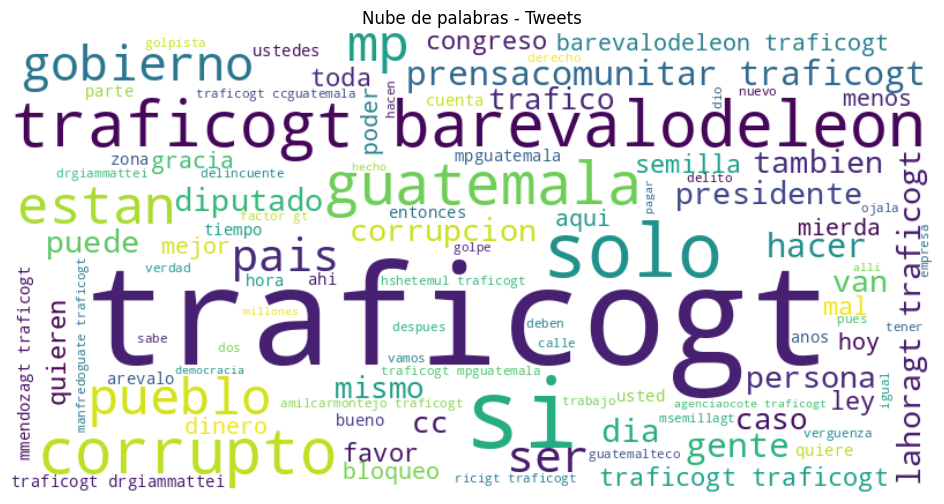

In [194]:
texto = ' '.join(df['contenido_limpio'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(texto)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nube de palabras - Tweets")
plt.show()

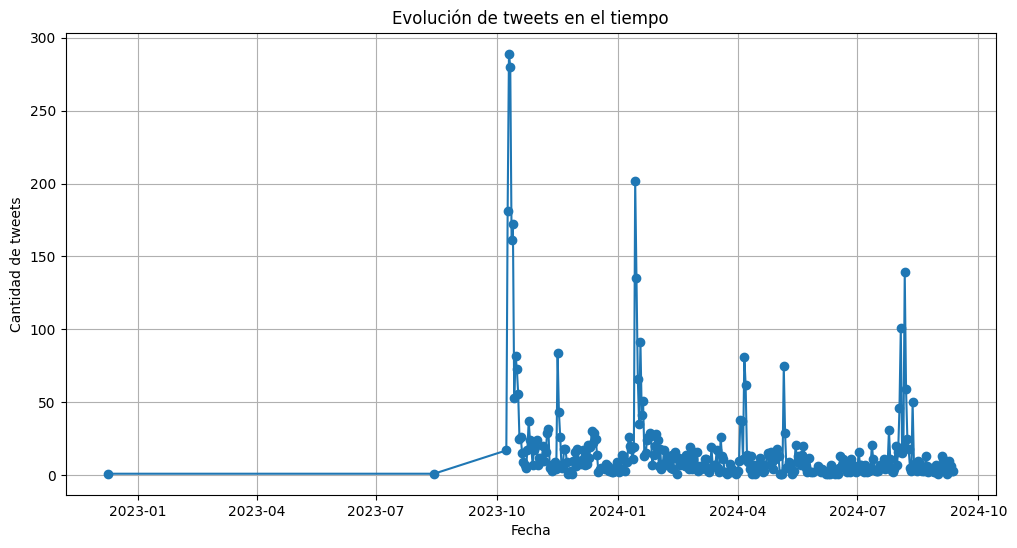

In [195]:
tweets_por_fecha = df.groupby(df['fecha'].dt.date).size()
plt.figure(figsize=(12,6))
tweets_por_fecha.plot(kind='line', marker='o')
plt.title("Evolución de tweets en el tiempo")
plt.ylabel("Cantidad de tweets")
plt.xlabel("Fecha")
plt.grid(True)
plt.show()